### Generate linear system
description of the equation and discretization is coming later


In [4]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.pyplot as plt
import time


In [5]:
def a(x, y):
    assert(y.shape[1] == 1 and x.shape[1] == 1) # outer product - the other dimensions of the vectors are not necessarily the same
    return np.cos(y) * np.cos(x.T)

def u(x, y):
    return np.sin(4*np.pi*y) * np.sin(2*np.pi*x.T)

def f(x, y):
    a1 = np.multiply(np.cos(y), np.sin(4*np.pi*y))
    a2 = np.multiply(np.sin(x.T), np.cos(2*np.pi*x.T))
    a3 = np.multiply(np.cos(x.T), np.sin(2*np.pi*x.T))
    a4 = np.multiply(np.sin(y), np.cos(4*np.pi*y))
    a5 = np.multiply(np.cos(y), np.sin(4*np.pi*y))
    a6 = np.multiply(np.cos(x.T), np.sin(2*np.pi*x.T))
    return  2*np.pi*a1*(a2+2*np.pi*a3) + 4*np.pi*(a4+4*np.pi*a5)*a6

def a1(i, j):
    return 0.5 * (a(x[i], y[j]) + a(x[i-1], y[j]))
def a2(i, j):
    return 0.5 * (a(x[i], y[j]) + a(x[i], y[j-1]))

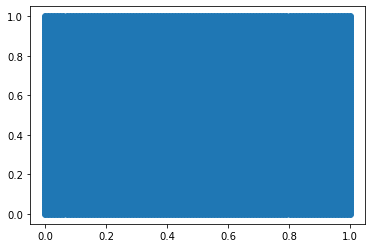

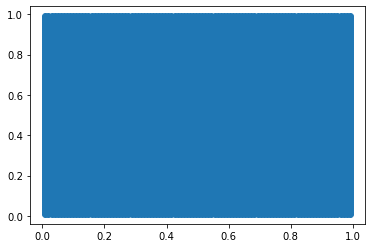

In [6]:
N = 100 # number of internal points of the grid
Nx = N
Ny = N
dx = 1 / (Nx + 1)
x = np.linspace(0, 1, Nx+2).reshape(Nx+2, 1)
xi = x[1:-1].reshape(Nx, 1)  # interior points N

# in y direction
dy = dx
y = x.copy()
yi = xi.copy()

xv, yv = np.meshgrid(x, y)  # the whole grid
xiv, yiv = np.meshgrid(xi, yi)  # interior grid only

# plot the whole grid and internal points
plt.scatter(xv, yv)
plt.show()
plt.scatter(xiv, yiv)
plt.show()


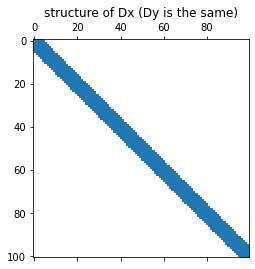

In [7]:
A1=0.5*a(x[:-1], yi) + 0.5*a(x[1:], yi)
A2=0.5*a(xi, y[:-1]) + 0.5*a(xi, y[1:])

Dx = sp.sparse.diags([1, -1], [0, -1], shape=(Nx+1, Nx))
Dy = sp.sparse.diags([1, -1], [0, -1], shape=(Ny+1, Ny))

plt.spy(Dx)
plt.title('structure of Dx (Dy is the same)')
plt.show()

Ix = sp.sparse.diags([1], [0], shape=(Nx, Nx))
Iy = sp.sparse.diags([1], [0], shape=(Ny, Ny))

A1_diag = sp.sparse.diags(A1.T.reshape(1, (Nx+1)*Ny), [0], shape=((Nx+1)*Ny, (Nx+1)*Ny)) # spdiags can be used
A2_diag = sp.sparse.diags(A2.T.reshape(1, (Ny+1)*Nx), [0], shape=((Ny+1)*Nx, (Ny+1)*Nx))

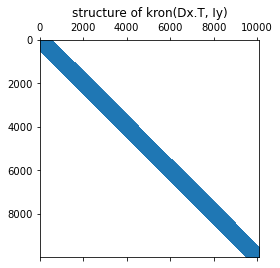

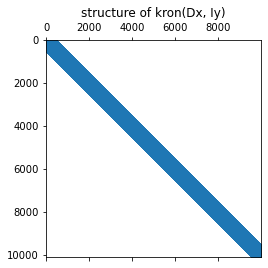

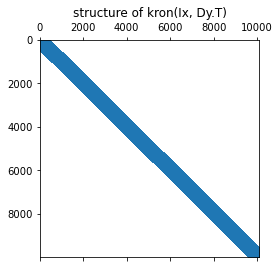

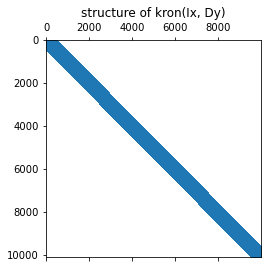

In [8]:
plt.spy(sp.sparse.kron(Dx.T, Iy))
plt.title('structure of kron(Dx.T, Iy)')
plt.show()
plt.spy(sp.sparse.kron(Dx, Iy))
plt.title('structure of kron(Dx, Iy)')
plt.show()
plt.spy(sp.sparse.kron(Ix, Dy.T))
plt.title('structure of kron(Ix, Dy.T)')
plt.show()
plt.spy(sp.sparse.kron(Ix, Dy))
plt.title('structure of kron(Ix, Dy)')
plt.show()

In [9]:
L = sp.sparse.kron(Dx.T, Iy) @ A1_diag @ sp.sparse.kron(Dx, Iy) # symmetric matrix
R = sp.sparse.kron(Ix, Dy.T) @ A2_diag @ sp.sparse.kron(Ix, Dy) # symmetric matrix
A = L/dx**2 + R/dy**2  # defined for the internal points only

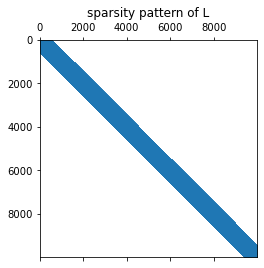

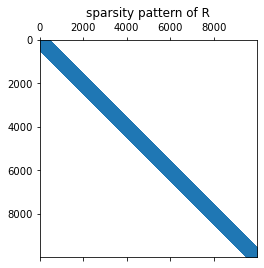

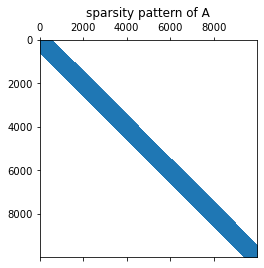

In [10]:
# plot sparsity pattern of the matrix A
plt.spy(L)
plt.title('sparsity pattern of L')
plt.show()
plt.spy(R)
plt.title('sparsity pattern of R')
plt.show()
plt.spy(A)
plt.title('sparsity pattern of A')
plt.show()

In [11]:
# right hand side (internal points only)
F = f(xi, yi)
Fvec = F.reshape(((Nx)*(Ny), 1))


In [12]:
t0 = time.time()
# direct solution
Uvec = sp.sparse.linalg.spsolve(A, Fvec)
t1 = time.time()
U = Uvec.reshape(Nx, Ny)
print("Matrix size: {}".format(Nx*Ny))
print("Direct solver: time elapsed: {} seconds".format(t1-t0))


Matrix size: 10000
Direct solver: time elapsed: 0.14561891555786133 seconds


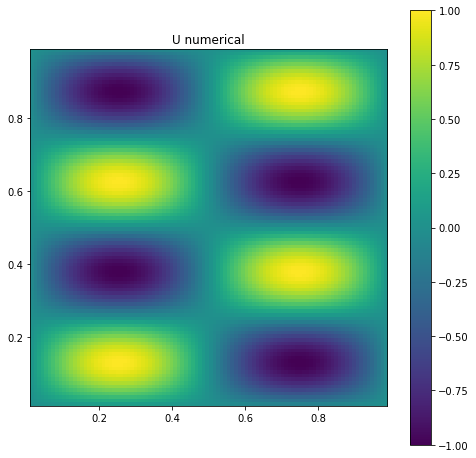

In [13]:
plt.figure(figsize=(8, 8))
plt.title("U numerical")
plt.imshow(U, vmin=U.min(), vmax=U.max(), origin='lower', extent=[xi.min(), xi.max(), yi.min(), yi.max()])
# plt.scatter(xiv, yiv, c=np.abs(U)/np.abs(U).max())
plt.colorbar()
plt.show()

### Sample exact solution

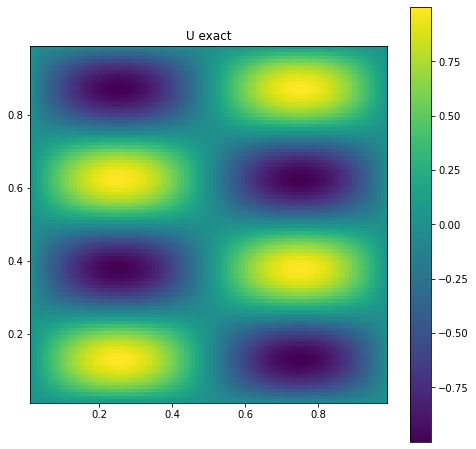

In [14]:
Uexact = u(xi.reshape(Nx, 1), yi.reshape(Ny, 1))
Uexactvec = Uexact.reshape(Nx*Ny, 1)
plt.figure(figsize=(8, 8))
plt.title("U exact")
plt.imshow(Uexact, vmin=(Uexact).min(), vmax=(Uexact).max(),
           origin='lower', extent=[xi.min(), xi.max(), yi.min(), yi.max()])
# plt.scatter(xv[1:-1, 1:-1], yv[1:-1, 1:-1], c=Uexact[:, :])
plt.colorbar()
plt.show()

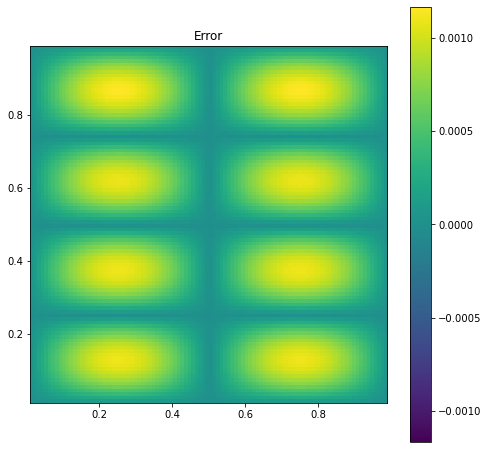

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Error")
plt.imshow(np.abs(Uexact-U), vmin=(Uexact-U).min(), vmax=(Uexact-U).max(),
           origin='lower', extent=[xi.min(), xi.max(), yi.min(), yi.max()])
# plt.scatter(xv[1:-1, 1:-1], yv[1:-1, 1:-1], c=Uexact[:, :])
plt.colorbar()
plt.show()

In [16]:
Fvec.shape

(10000, 1)

In [17]:
# let's write
# 1. matrix
# 2. rhs
# 3. exact solution
# into the .csv files

import csv

g = Fvec

with open('b.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['row', 'val'])
    for (n), val in np.ndenumerate(g):
        writer.writerow([n, val])

In [18]:
sp.sparse.save_npz("A.npz", A)

### Plot spectrum of the matrix

In [19]:
# plot spectrum of the matrix

w, _ = sp.sparse.linalg.eigs(A, k=Nx*Ny-2)
plt.scatter(range(Nx*Ny-2), np.sort(w), marker='.')
plt.title('Spectrum of the matrix A')
plt.show()

KeyboardInterrupt: 

### Condition number

In [ ]:
print("Condition number of A: ", w.max()/w.min())
# Estimate for big matrices

### Check if the matrix is symmetric and positive definite

In [20]:
# test if the matrix A is symmetric and positive definite
if (sp.sparse.linalg.norm(A-A.T, 'fro') == 0):
    print('matrix A is real symmetric')
if (sp.sparse.linalg.eigs(A, k=1, which='SR', return_eigenvectors=False) > 0):
    print('the matrix is positive definite')

matrix A is real symmetric
the matrix is positive definite


## Iterative solvers

### Jacobi iteration

In [21]:
# x is the exact solution for the relative error
# x is exact solution
def jacobi(A, b, x0, x, tol=1e-15, maxiter=50): # A is a sparse matrix; better to use csc format
    err = list(); res = list()
    D = sp.sparse.spdiags(A.diagonal(), 0, A.shape[0], A.shape[1], format='csc')
    Dinv = sp.sparse.spdiags(1/(A.diagonal()), 0, A.shape[0], A.shape[1], format='csc')
    L = -sp.sparse.tril(A, -1)
    U = -sp.sparse.triu(A, 1)
    LU = L + U
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    xk = x0
    iter_count = 0
    rk = np.linalg.norm(b - A*xk) / bnorm
    res.append(rk)
    err.append(np.linalg.norm(x - xk) / xnorm)
    while (iter_count > maxiter and rk > tol):
        xk = LU*xk + b
        xk = Dinv*xk
        rk = np.linalg.norm(b - A*xk) / bnorm
        res.append(rk)
        err.append(np.linalg.norm(x - xk) / xnorm)
        iter_count += 1
    return xk, res, err

### Weighted Jacobi iteration


In [22]:
def weight_jacobi(A, b, x0, x, tol=1e-15, maxiter=100, w=2/3): # it's just Jacobi for w=1
    err = list();
    res = list()
    Dw = sp.sparse.spdiags(A.diagonal()/w, 0, A.shape[0], A.shape[1], format='csc')
    Dwinv = sp.sparse.spdiags(w/A.diagonal(), 0, A.shape[0], A.shape[1], format='csc')
    M = Dw - A # not completely without diagonal, but with a normalized diagonal
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    xk = x0
    iter_count = 0
    rk = np.linalg.norm(b - A * xk) / bnorm
    res.append(rk)
    err.append(np.linalg.norm(x - xk) / xnorm)
    while (iter_count < maxiter and rk > tol):
        xk = M*xk + b
        xk = Dwinv*xk
        rk = np.linalg.norm(b - A * xk) / bnorm
        res.append(rk)
        err.append(np.linalg.norm(x - xk) / xnorm)
        iter_count += 1
    return xk, res, err

### Gauss-Seidel iteration


In [23]:
def gauss_seidel(A, b, x0, x, tol=1e-15, maxiter=100):
    err = list();
    res = list()
    D = sp.sparse.spdiags(A.diagonal(), 0, A.shape[0], A.shape[1], format='csc')
    L = -sp.sparse.tril(A, -1)
    U = -sp.sparse.triu(A, 1)
    DLinv = sp.sparse.linalg.inv(D - L)

    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    xk = x0
    iter_count = 0
    rk = np.linalg.norm(b - A * xk) / bnorm
    res.append(rk)
    err.append(np.linalg.norm(x - xk) / xnorm)

    while (iter_count < maxiter and rk > tol):
        xk = U*xk + b
        xk = DLinv*xk
        rk = np.linalg.norm(b - A*xk) / bnorm
        res.append(rk)
        err.append(np.linalg.norm(x - xk) / xnorm)
        iter_count += 1

    return xk, res, err

### Successive Overrelaxation (SOR)


In [24]:
def sor(A, b, x0, x, tol=1e-15, maxiter=100, w=2/3):
    err = list();
    res = list()
    D = sp.sparse.spdiags(A.diagonal(), 0, A.shape[0], A.shape[1], format='csc')
    L = -sp.sparse.tril(A, -1)
    U = -sp.sparse.triu(A, 1)
    DwLinv = sp.sparse.linalg.inv(D - w*L)
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    xk = x0
    iter_count = 0
    rk = np.linalg.norm(b - A * xk) / bnorm
    res.append(rk)
    err.append(np.linalg.norm(x - xk) / xnorm)

    while (iter_count < maxiter and rk > tol):
        xk = ((1-w)*D + w*U)*xk + w*b
        xk = DwLinv*xk
        rk = np.linalg.norm(b - A*xk) / bnorm
        res.append(rk)
        err.append(np.linalg.norm(x - xk) / xnorm)
        iter_count += 1
    return xk, res, err


**Q: What parameters are used in SOR?**
**A: $w=\frac23$ but it's not optimal; not sure if it minimizes spectral radius of $M$**

**Q: What is the size of the matrix $A$?**

In [25]:
print('Size of the matrix A is: {} by {} elements.'.format(A.shape[0], A.shape[1]))

Size of the matrix A is: 10000 by 10000 elements.


### Steepest descent


In [26]:
def quadratic_cost_f(A, x, b):
    return float(-0.5*(x.T@(A@x)) + x.T@b)

In [27]:
def sd(A, b, x0, x, tol=1e-15, maxiter=100):
    err = list()
    res = list()
    cost = list()
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    xk = x0
    iter_count = 0
    rk = b - A@xk
    rknorm = np.linalg.norm(rk)/bnorm
    res.append(rknorm)
    err.append(np.linalg.norm(x - xk) / xnorm)
    cost.append(quadratic_cost_f(A, xk, b))

    while (iter_count < maxiter and rknorm > tol):
        rk = b - A@xk
        rknorm = np.linalg.norm(rk)/bnorm
        aux1 = rk.T@rk
        aux2 = rk.T@(A@rk)
        alphak = aux1 / aux2
        xk = xk + alphak*rk

        res.append(np.linalg.norm(rk) / bnorm)
        err.append(np.linalg.norm(x - xk) / xnorm)
        cost.append(quadratic_cost_f(A, xk, b))
        iter_count += 1

    return xk, res, err, cost

### Conjugate gradient

In [28]:
def cg(A, b, x0, x, tol=1e-15, maxiter=10):

    xk = x0 # x0
    rk = A.dot(xk) - b # r0
    pk = -rk # p0
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    rk_norm = np.linalg.norm(rk)/ bnorm # normalized residual at the initial iteration

    res = [rk_norm] # accumulates residuals rk_norm at each iteration
    err = [np.linalg.norm(x - xk)/xnorm]
    cost = [quadratic_cost_f(A, xk, b)]

    num_iter = 0 # iteration counter

    while (rk_norm > tol and num_iter < maxiter): # norm of the residual at the current iteration is greater than the preset tolerance

        apk = A.dot(pk) # numpy vector in both sparse and non-sparse cases
        rkrk = np.dot(rk.T, rk)[0, 0] # since the vectors are numpy arrays, columns
        alpha = rkrk / np.dot(pk.T, apk)[0][0]

        xk = xk + alpha * pk # x(k+1)

        rk = rk + alpha * apk

        beta = np.dot(rk.T, rk)[0][0] / rkrk

        pk = -rk + beta * pk # p(k+1)

        num_iter += 1

        rk_norm = np.linalg.norm(rk) / bnorm # normalized residual at the k-th iteration
        res.append(rk_norm)
        err.append(np.linalg.norm(x - xk)/xnorm)
        cost.append(quadratic_cost_f(A, xk, b))

    return xk, res, err, cost


### Preconditioned Conjugate Gradient


In [29]:
# for both sparse and non-sparse formats
# for split preconditioner
def pcg(A, b, x0, x, Ml, Mr, atol=1e-15, maxiter=10):

    xk = x0 # x0
    rk = A.dot(xk) - b # r0
    # with hat
    rk = Ml.dot(rk)
    pk = -Mr.dot(rk) # p0

    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    rk_norm = np.linalg.norm(rk) / bnorm # normalized residual at the initial iteration

    res = [rk_norm] # accumulates residuals rk_norm at each iteration
    err = [np.linalg.norm(x - xk) / xnorm]
    cost = [quadratic_cost_f(A, xk, b)]

    num_iter = 0 # iteration counter
    curve_x = [xk] # to plot the vectors as the algorithm converges
    while rk_norm > atol and num_iter < maxiter: # norm of the residual at the current iteration is greater than the preset tolerance

        apk = A.dot(pk) # numpy vector in both sparse and non-sparse cases
        rkrk = np.dot(rk.T, rk)[0, 0] # since the vectors are numpy arrays, columns
        alpha = rkrk / np.dot(pk.T, apk)[0][0]

        xk = xk + alpha * pk # x(k+1)

        rk = rk + alpha * Ml.dot(apk)

        beta = np.dot(rk.T, rk)[0][0] / rkrk

        pk = -Mr.dot(rk) + beta * pk # p(k+1)

        num_iter += 1

        curve_x.append(xk)
        rk_norm = np.linalg.norm(rk) / np.linalg.norm(b) # normalized residual at the k-th iteration
        res.append(rk_norm)
        err.append(np.linalg.norm(x - xk) / xnorm)
        cost.append(quadratic_cost_f(A, xk, b))

    return xk, res, err, cost


### Unpreconditioned Biconjugate Gradient

In [30]:
def bicg(A, b, x0, x, tol=1e-15, maxiter=10):

    xk = x0
    rk = b - (A @ xk)
    rhk = rk
    pk = rk
    phk = rhk

    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    rk_norm = np.linalg.norm(rk) / bnorm

    res = [rk_norm] # accumulates residuals rk_norm at each iteration
    err = [np.linalg.norm(x - xk) / xnorm]
    cost = [quadratic_cost_f(A, xk, b)]

    iter_count = 0

    while (rk_norm > tol and iter_count < maxiter):
        apk = A @ pk
        rhk_rk = rhk.T @ rk

        alpha = rhk_rk / (phk.T @ apk)

        xk = xk + alpha * pk
        rk = rk - alpha * apk
        rhk = rhk - alpha * (A.T @ phk)

        beta = (rhk.T @ rk) / rhk_rk

        pk = rk + beta * pk
        phk = rhk + beta * phk

        iter_count += 1

        rk_norm = np.linalg.norm(rk) / bnorm # normalized residual at the k-th iteration
        res.append(rk_norm)
        err.append(np.linalg.norm(x - xk)/xnorm)
        cost.append(quadratic_cost_f(A, xk, b))

    return xk, res, err, cost

### Preconditioned Biconjugate Gradient

In [1]:
def pbicg(A, b, x0, x, Ml, Mr, tol=1e-15, maxiter=10):
    
    xk = x0
    rk = b - (A @ xk)
    
    rk = Ml @ rk
    pk = Mr @ rk
    rhk = rk
    phk = pk
    
    bnorm = np.linalg.norm(b)
    xnorm = np.linalg.norm(x)
    rk_norm = np.linalg.norm(rk) / bnorm
    
    res = [rk_norm] # accumulates residuals rk_norm at each iteration
    err = [np.linalg.norm(x - xk) / xnorm]
    cost = [quadratic_cost_f(A, xk, b)]

    iter_count = 0
    
    while (rk_norm > tol and iter_count < maxiter):
        apk = A @ pk
        rhk_rk = rhk.T @ rk

        alpha = rhk_rk / (phk.T @ apk)

        xk = xk + alpha * pk
        rk = rk - alpha * (Ml @ apk)
        rhk = rhk - alpha * (Ml @ (A.T @ phk)) 

        beta = (rhk.T @ rk) / rhk_rk

        pk = (Mr @ rk) + beta * pk
        phk = (Mr @ rhk) + beta * phk
        
        iter_count += 1

        rk_norm = np.linalg.norm(rk) / bnorm # normalized residual at the k-th iteration
        res.append(rk_norm)
        err.append(np.linalg.norm(x - xk)/xnorm)
        cost.append(quadratic_cost_f(A, xk, b))

    return xk, res, err, cost
    

### Let's run the solvers

Maximum number of iteration is set to be a half of the size of the matrix $A$.

Initial solution $x_0$ is a zero vector.


In [31]:
# maxim_iter = int(A.shape[0]/2)
x_0 = np.zeros((A.shape[0], 1))
maxim_iter = 300

In [32]:
_, res_jac, err_jac = jacobi(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter)

In [33]:
_, res_wjac, err_wjac = weight_jacobi(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter, w=2/3)

In [34]:
_, res_gs, err_gs = gauss_seidel(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter)

In [35]:
_, res_sor, err_sor = sor(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter, w=2/3)

In [36]:
_, res_sd, err_sd, cost_sd = sd(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter)

In [37]:
_, res_cg, err_cg, cost_cg = cg(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter)

In [38]:
_, res_bicg, err_bicg, cost_bicg = bicg(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter)

### Using Jacobi preconditioner

In [39]:
# Jacobi preconditioner -- left and right parts are the same Ml == Mr
Ml_jac = sp.sparse.lil_matrix((Nx*Ny, Nx*Ny), dtype=np.float64)
for i in range(Nx*Ny):
    Ml_jac[i, i] = 1 / np.sqrt(A[i, i])
Ml_jac = Ml_jac.tocsc()

_, res_pcg, err_pcg, cost_pcg = pcg(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter, Mr=Ml_jac, Ml=Ml_jac)

### Using Incomplete LU preconditioner (ILU)


In [40]:
A_ilu = sp.sparse.linalg.spilu(A.tocsc())

M_ilu = sp.sparse.linalg.LinearOperator((A.shape[0],A.shape[1]), A_ilu.solve)
M_ilu = M_ilu.dot(np.identity(A.shape[0]))
M_ilu = sp.sparse.csc_matrix(M_ilu)

M_L = -sp.sparse.tril(M_ilu, -1)
M_U = -sp.sparse.triu(M_ilu, 1)

_, res_pcglu, err_pcglu, cost_pcglu = pcg(A, Fvec, x0=x_0, x=Uexactvec, maxiter=maxim_iter, Mr=M_U, Ml=M_L)

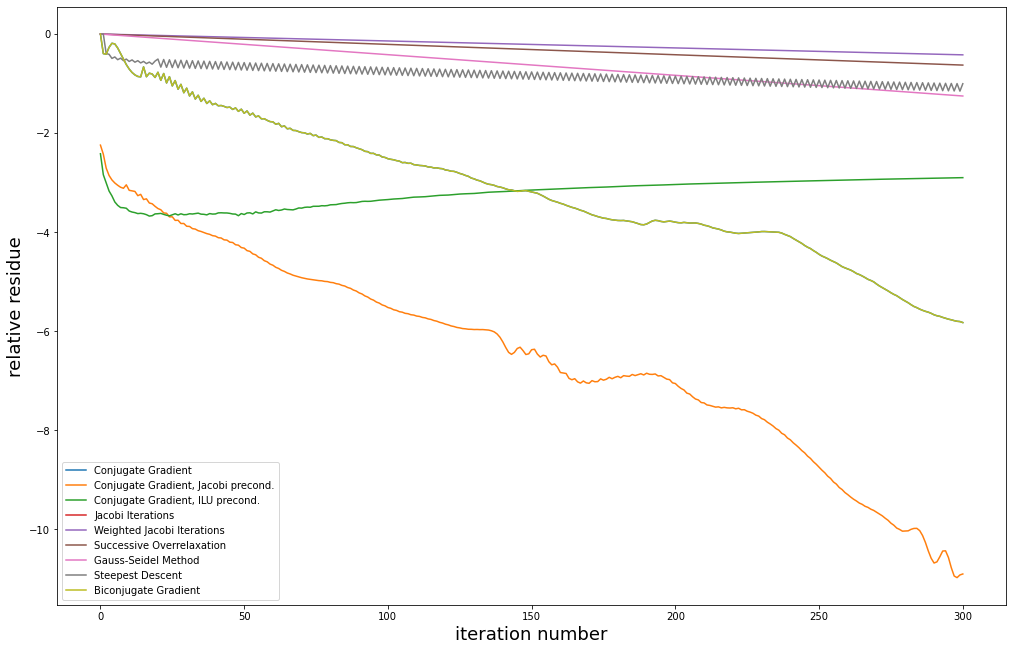

In [43]:
plt.figure(figsize=(17, 11))
plt.plot(np.log10(res_cg), label='Conjugate Gradient')
plt.plot(np.log10(res_pcg), label='Conjugate Gradient, Jacobi precond.')
plt.plot(np.log10(res_pcglu), label='Conjugate Gradient, ILU precond.')
plt.plot(np.log10(res_jac), label='Jacobi Iterations')
plt.plot(np.log10(res_wjac), label='Weighted Jacobi Iterations')
plt.plot(np.log10(res_sor), label='Successive Overrelaxation')
plt.plot(np.log10(res_gs), label='Gauss-Seidel Method')
plt.plot(np.log10(res_sd), label='Steepest Descent')
plt.plot(np.log10(res_bicg), label='Biconjugate Gradient')

plt.ylabel('relative residue', fontsize=18)
plt.xlabel('iteration number', fontsize=18)
plt.legend()